In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as f
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class CNN(nn.Module):
    def __init__(self, in_channel=1, num_classes=10):
        super(CNN, self).__init__()
        self.my_cnn = nn.Sequential(
            nn.Conv2d(in_channels=in_channel, out_channels=8, kernel_size=(3,3), stride=(1,1), padding=(1,1)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3,3), stride=(1,1), padding=(1,1)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))
        )
        self.my_nn = nn.Sequential(
            nn.Linear(16*7*7, 1024),  # Adjusted the input size for the fully connected layer
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(1024, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(256, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x = self.my_cnn(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.my_nn(x)
        return x

In [3]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(DEVICE)

cpu


In [4]:
input_size = 784
num_classes = 10
learning_rate = 1e-3
batch_size = 64
num_epochs = 5

In [5]:
train_dataset = datasets.MNIST(root='dataset/', train=True, transform=transforms.ToTensor(), download=True)
train_loader = DataLoader(dataset=train_dataset, shuffle=True, batch_size=batch_size, drop_last=True)

test_dataset = datasets.MNIST(root='dataset/', train=False, transform=transforms.ToTensor(), download=True)
test_loader = DataLoader(dataset=test_dataset, shuffle=True, batch_size=batch_size)

In [6]:
print(len(train_dataset))
print(len(train_loader))

60000
937


In [7]:
model = CNN()
model = model.to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [8]:
def compute_accuracy(model, loader):
    model.eval()
    num_correct = 0
    num_smaples = 0

    with torch.no_grad():
        for data, targets in loader:
            data = data.to(DEVICE)
            targets = targets.to(DEVICE)

            # data = data.reshape(data.shape[0], -1)

            logits = model(data)
            _, predictions = logits.max(1)
            num_correct += (predictions == targets).sum()
            num_smaples += predictions.size(0)

        acc = num_correct/num_smaples*100
        return acc
    

def compute_loss(model, X_loader):

    model.eval()
    with torch.no_grad():
        epoch_loss = 0
        for inputs, targets in X_loader:
            inputs = inputs.to(DEVICE)
            targets = targets.to(DEVICE)
            logits = model.forward(inputs)
            loss = torch.nn.functional.cross_entropy(logits, targets.view(-1))
            epoch_loss += loss.item()
        avg_loss = epoch_loss / len(X_loader)
        return avg_loss

In [9]:
train_acc_data = []
test_acc_data = []
train_loss_data = []
test_loss_data = []

for epoch in range(num_epochs):

    for batch_idx, (data, targets) in enumerate(train_loader):
        model.train()
        data = data.to(DEVICE)
        targets = targets.to(DEVICE)

        # data = data.reshape(data.shape[0], 28, 28)
        
        logits = model(data)
        loss = criterion(logits, targets)

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()

        with torch.no_grad():
            if (batch_idx%50) == 0:
                print(f'epoch - {epoch+1}/{num_epochs} || batch_idx = {batch_idx}/{len(train_loader)}')
        
    with torch.no_grad():
        train_accuracy = compute_accuracy(model, train_loader)
        test_accuracy = compute_accuracy(model, test_loader)
        train_loss = compute_loss(model, train_loader)
        test_loss = compute_loss(model, test_loader)

        train_acc_data.append(train_accuracy)
        test_acc_data.append(test_accuracy)
        train_loss_data.append(train_loss)
        test_loss_data.append(test_loss)

        print(f'epoch - {epoch+1} || train_accuracy - {train_accuracy} || test_accuracy - {test_accuracy} || train_loss - {train_loss} || test_loss - {test_loss}')

epoch - 1/5 || batch_idx = 0/937


epoch - 1/5 || batch_idx = 50/937
epoch - 1/5 || batch_idx = 100/937
epoch - 1/5 || batch_idx = 150/937
epoch - 1/5 || batch_idx = 200/937
epoch - 1/5 || batch_idx = 250/937
epoch - 1/5 || batch_idx = 300/937
epoch - 1/5 || batch_idx = 350/937
epoch - 1/5 || batch_idx = 400/937
epoch - 1/5 || batch_idx = 450/937
epoch - 1/5 || batch_idx = 500/937
epoch - 1/5 || batch_idx = 550/937
epoch - 1/5 || batch_idx = 600/937
epoch - 1/5 || batch_idx = 650/937
epoch - 1/5 || batch_idx = 700/937
epoch - 1/5 || batch_idx = 750/937
epoch - 1/5 || batch_idx = 800/937
epoch - 1/5 || batch_idx = 850/937
epoch - 1/5 || batch_idx = 900/937
epoch - 1 || train_accuracy - 98.55590057373047 || test_accuracy - 98.16999816894531 || train_loss - 0.04927601277720871 || test_loss - 0.05621066145824304
epoch - 2/5 || batch_idx = 0/937
epoch - 2/5 || batch_idx = 50/937
epoch - 2/5 || batch_idx = 100/937
epoch - 2/5 || batch_idx = 150/937
epoch - 2/5 || batch_idx = 200/937
epoch - 2/5 || batch_idx = 250/937
epoch - 

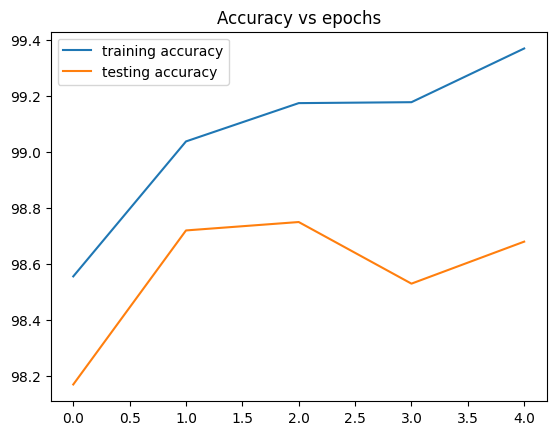

In [10]:
plt.plot(range(len(train_acc_data)), train_acc_data, label = 'training accuracy')
plt.plot( range(len(test_acc_data)), test_acc_data, label = 'testing accuracy')

plt.title('Accuracy vs epochs')

plt.legend()
plt.show()

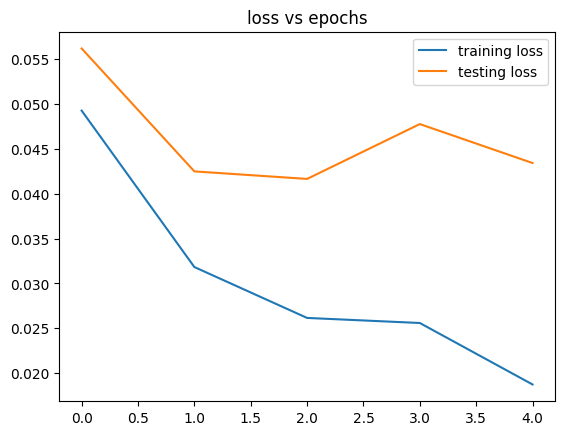

In [11]:
plt.plot(range(len(train_loss_data)), train_loss_data, label = 'training loss')
plt.plot( range(len(test_loss_data)), test_loss_data, label = 'testing loss')

plt.title('loss vs epochs')

plt.legend()
plt.show()